# Comprehensive Traffic Control System Evaluation

**Purpose:** Complete evaluation comparing Q-Learning agent against two baselines:
1. Fixed-Time Controller
2. Actuated Controller

**Generates:**
- Figure 1: Learning Curve
- Figure 2: Three-Way Performance Comparison
- Figure 3: Statistical Analysis with Significance Tests

## 1. Setup and Imports

In [30]:
import os
import sys
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Add src to path
sys.path.append(os.path.abspath('..'))

from src.simulation.environment import JammingMachine
from src.agent.q_learning_agent import QLearningAgent

print("✓ All imports successful")

✓ All imports successful


## 2. Configuration

In [31]:
# Cell #2 - Configuration
SIM_CONFIG_PATH = "../config/sim_config.json"  # Naik 1 level ke parent
Q_TABLE_PATH = "../trained_q_table.json"
LOG_FILE_PATH = "../training_log.json"

# Evaluation parameters
NUM_EVALUATION_EPISODES = 100
CONFIDENCE_LEVEL = 0.95

# Output
RESULTS_OUTPUT_DIR = "../results"  # Save ke results di root
os.makedirs(RESULTS_OUTPUT_DIR, exist_ok=True)

print(f"✓ Configuration loaded. Will run {NUM_EVALUATION_EPISODES} episodes per agent.")

✓ Configuration loaded. Will run 100 episodes per agent.


## 3. Load Trained Q-Learning Agent

In [32]:
# Load simulation config
with open(SIM_CONFIG_PATH, 'r') as f:
    sim_config = json.load(f)

# Load initial state - ADA DI FOLDER DATA!
try:
    with open('../data/initial_state.json', 'r') as f:  # FIXED: di data/ bukan config/
        initial_state = json.load(f)
        print("✓ Initial state loaded from data/initial_state.json")
except:
    initial_state = None
    print("⚠ No initial_state.json found, using default")

# Create environment
env = JammingMachine(sim_config, initial_state)

# Calculate state and action space from environment structure
STATE_SPACE_SIZE = 8   # 4 lanes × 2 values (normalized count + density)
ACTION_SPACE_SIZE = 6  # Short/Normal/Long for NS and EW

print(f"✓ Environment created")
print(f"  State space: {STATE_SPACE_SIZE} dimensions")
print(f"  Action space: {ACTION_SPACE_SIZE} actions")

# Load trained Q-Learning agent
with open(Q_TABLE_PATH, 'r') as f:
    q_table_data = json.load(f)

trained_agent = QLearningAgent(
    state_space_size=STATE_SPACE_SIZE,
    action_space_size=ACTION_SPACE_SIZE,
    learning_rate=0.1,
    discount_factor=0.95,
    exploration_rate=0.0
)

trained_agent.q_table = {tuple(map(int, k.strip('()').split(','))): v for k, v in q_table_data.items()}

print(f"✓ Q-Learning agent loaded with {len(trained_agent.q_table)} state-action pairs")

✓ Initial state loaded from data/initial_state.json
TrafficModel initialized.
RewardCalculator initialized with weights:
  Throughput: 0.45
  Queue:      0.30
  Waiting:    0.15
  Fairness:   0.10
Jamming Machine environment initialized.
✓ Environment created
  State space: 8 dimensions
  Action space: 6 actions
QLearningAgent initialized with 5 bins.
State space size: 5^8 = 390,625 possible states
✓ Q-Learning agent loaded with 379 state-action pairs


## 4. FIGURE 1: Learning Curve

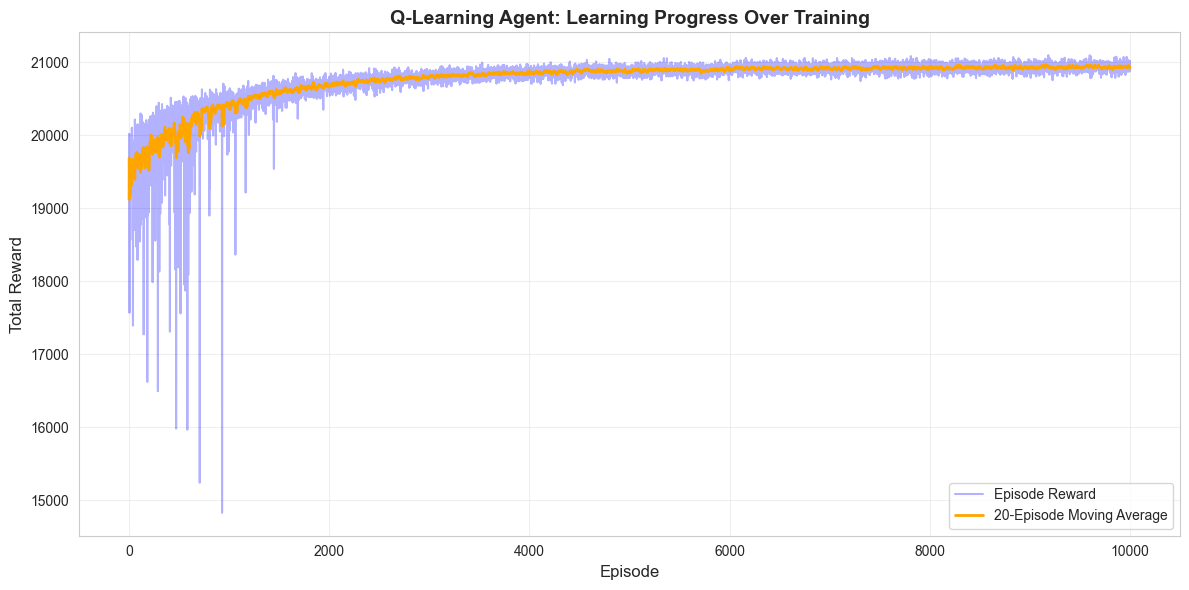

✓ Figure 1 saved: figure_1_learning_curve.png


In [33]:
# Load training log
with open(LOG_FILE_PATH, 'r') as f:
    training_log = json.load(f)

episodes = [entry['episode'] for entry in training_log]
rewards = [entry['total_reward'] for entry in training_log]

# Calculate moving average
window_size = 20
moving_avg = pd.Series(rewards).rolling(window=window_size, min_periods=1).mean()

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(episodes, rewards, alpha=0.3, color='blue', label='Episode Reward')
ax.plot(episodes, moving_avg, color='orange', linewidth=2, label=f'{window_size}-Episode Moving Average')
ax.set_xlabel('Episode', fontsize=12)
ax.set_ylabel('Total Reward', fontsize=12)
ax.set_title('Q-Learning Agent: Learning Progress Over Training', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f'{RESULTS_OUTPUT_DIR}/figure_1_learning_curve.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Figure 1 saved: figure_1_learning_curve.png")

## 5. Define Baseline Controllers

In [34]:
class FixedTimeAgent:
    """Fixed-time controller with predefined cycle"""
    def __init__(self):
        self.action_sequence = [1, 4]  # Normal NS, Normal EW
        self.steps_per_action = 30
        self.current_step = 0
        self.action_index = 0
    
    def choose_action(self, state):
        if self.current_step > 0 and self.current_step % self.steps_per_action == 0:
            self.action_index = (self.action_index + 1) % len(self.action_sequence)
        self.current_step += 1
        return self.action_sequence[self.action_index]
    
    def reset(self):
        self.current_step = 0
        self.action_index = 0


class ActuatedController:
    """Vehicle-actuated controller that responds to traffic demand"""
    def __init__(self):
        self.current_phase = "NS"
    
    def choose_action(self, state):
        # state format: [N, S, E, W, ...]
        ns_demand = state[0] + state[1]
        ew_demand = state[2] + state[3]
        
        if self.current_phase == "NS":
            if ns_demand < 5:
                action = 0  # Short
            elif ns_demand < 10:
                action = 1  # Normal
            else:
                action = 2  # Long
        else:
            if ew_demand < 5:
                action = 3
            elif ew_demand < 10:
                action = 4
            else:
                action = 5
        
        self.current_phase = "EW" if action < 3 else "NS"
        return action
    
    def reset(self):
        self.current_phase = "NS"

print("✓ Baseline controllers defined")

✓ Baseline controllers defined


## 6. Evaluation Function

In [35]:
def evaluate_agent_comprehensive(agent, environment, num_episodes, agent_name="Agent"):
    """
    Comprehensive evaluation with multiple performance metrics.
    
    Returns:
        dict: Contains rewards, queue_lengths, throughputs, avg_reward_per_vehicle
    """
    print(f"\nEvaluating {agent_name}...")
    
    results = {
        'rewards': [],
        'queue_lengths': [],
        'throughputs': [],
        'avg_reward_per_vehicle': []
    }
    
    for episode in range(num_episodes):
        if (episode + 1) % 20 == 0:
            print(f"  Progress: {episode + 1}/{num_episodes} episodes")
        
        # Reset environment and agent
        state = environment.reset()
        if hasattr(agent, 'reset'):
            agent.reset()
        
        done = False
        episode_reward = 0
        queue_samples = []
        
        while not done:
            action = agent.choose_action(state)
            state, reward, done, info = environment.step(action)
            
            # Collect metrics
            episode_reward += reward
            queue_samples.append(sum(environment.vehicle_counts.values()))
        
        # Store episode results
        results['rewards'].append(episode_reward)
        results['queue_lengths'].append(np.mean(queue_samples))
        results['throughputs'].append(info.get('total_departed', 0))
        
        # Calculate average reward per vehicle
        throughput = info.get('total_departed', 1)
        if throughput > 0:
            results['avg_reward_per_vehicle'].append(episode_reward / throughput)
        else:
            results['avg_reward_per_vehicle'].append(0)
    
    print(f"✓ {agent_name} evaluation complete.")
    return results

print("✓ Evaluation function ready")

✓ Evaluation function ready


## 7. Run All Evaluations

In [36]:
print("="*60)
print("STARTING COMPREHENSIVE EVALUATION")
print("="*60)

# Evaluate all three agents
rl_results = evaluate_agent_comprehensive(trained_agent, env, NUM_EVALUATION_EPISODES, "Q-Learning Agent")
fixed_results = evaluate_agent_comprehensive(FixedTimeAgent(), env, NUM_EVALUATION_EPISODES, "Fixed-Time Baseline")
actuated_results = evaluate_agent_comprehensive(ActuatedController(), env, NUM_EVALUATION_EPISODES, "Actuated Baseline")

print("\n✓ All evaluations complete!")

STARTING COMPREHENSIVE EVALUATION

Evaluating Q-Learning Agent...

[Reward Breakdown]
  Throughput:  50.00 (weight: 0.45) =  22.50
  Queue:       74.00 (weight: 0.30) =  22.20
  Waiting:     87.00 (weight: 0.15) =  13.05
  Fairness:    81.29 (weight: 0.10) =   8.13
  TOTAL:       65.88

[DEBUG Step 1]
  Departed: 10
  Queues: {'North': 13, 'South': 15, 'East': 17, 'West': 7}
  Waiting times: {'North': 13, 'South': 15, 'East': 17, 'West': 7}
  Reward: 65.88

[Reward Breakdown]
  Throughput:  50.00 (weight: 0.45) =  22.50
  Queue:       75.50 (weight: 0.30) =  22.65
  Waiting:     87.75 (weight: 0.15) =  13.16
  Fairness:    75.16 (weight: 0.10) =   7.52
  TOTAL:       65.83

[DEBUG Step 2]
  Departed: 10
  Queues: {'North': 15, 'South': 17, 'East': 13, 'West': 4}
  Waiting times: {'North': 15, 'South': 17, 'East': 13, 'West': 4}
  Reward: 65.83

[Reward Breakdown]
  Throughput:  45.00 (weight: 0.45) =  20.25
  Queue:       77.00 (weight: 0.30) =  23.10
  Waiting:     88.50 (weight: 0.15

KeyError: (0, 3, 2, 4, 3, 3, 0, 3)

## 8. FIGURE 2: Three-Way Performance Comparison

/var/folders/hr/vp89x7zs3p96600r917qvh9h0000gn/T/ipykernel_26828/3772191558.py:54: UserWarning: Glyph 9733 (\N{BLACK STAR}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/hr/vp89x7zs3p96600r917qvh9h0000gn/T/ipykernel_26828/3772191558.py:55: UserWarning: Glyph 9733 (\N{BLACK STAR}) missing from font(s) Arial.
  plt.savefig(f'{RESULTS_OUTPUT_DIR}/figure_2_three_way_comparison.png', dpi=300, bbox_inches='tight')


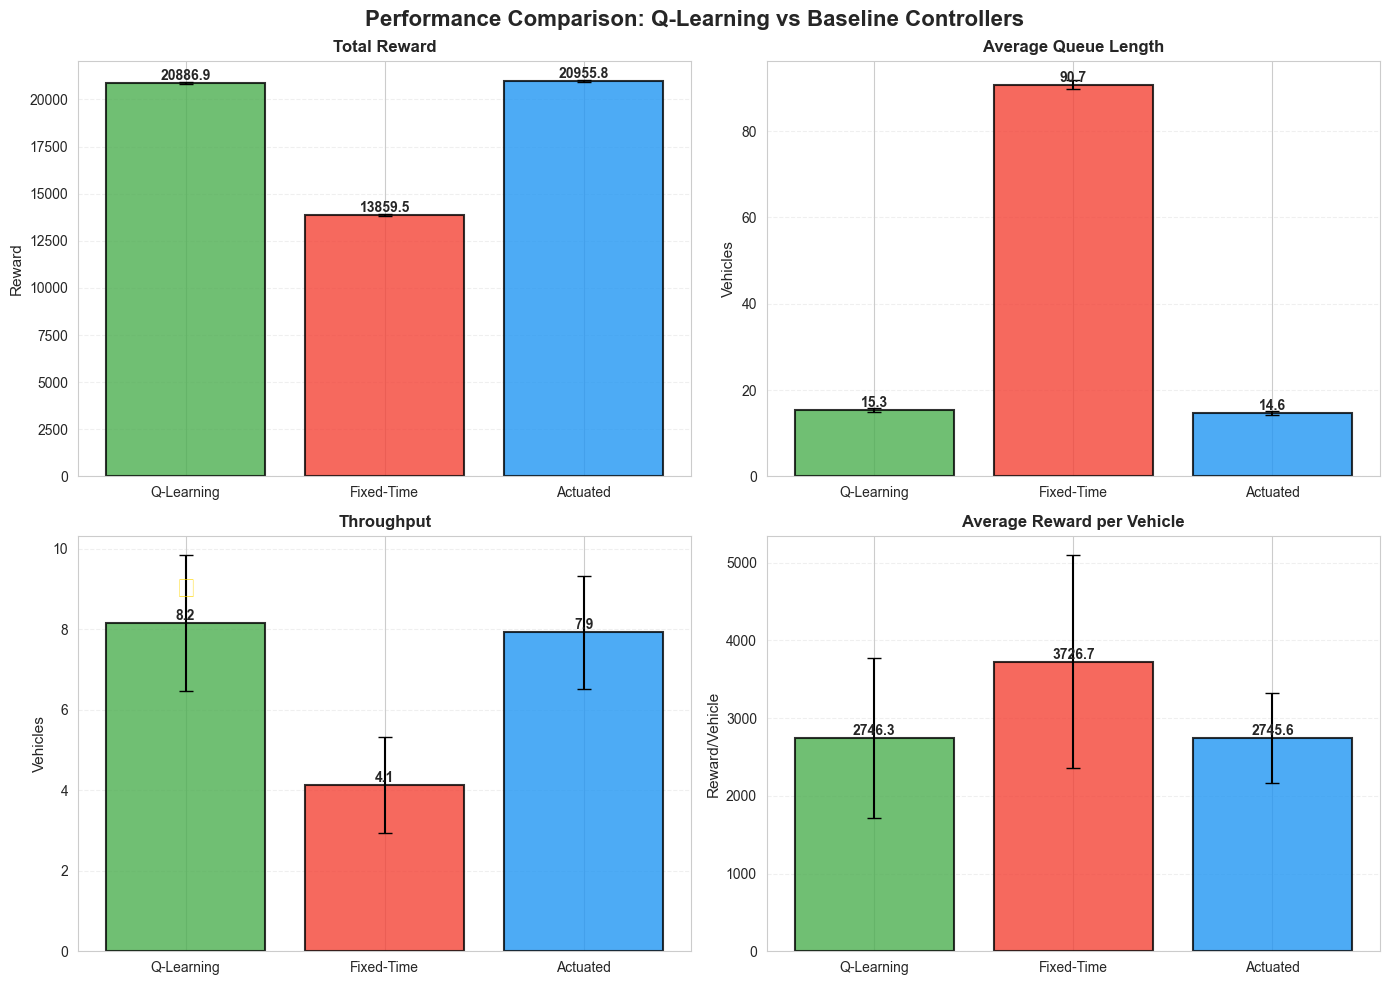

✓ Figure 2 saved: figure_2_three_way_comparison.png


In [ ]:
# Create comprehensive 3-way comparison plot
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Performance Comparison: Q-Learning vs Baseline Controllers', fontsize=16, fontweight='bold')

metrics_to_plot = ['rewards', 'queue_lengths', 'throughputs', 'avg_reward_per_vehicle']
metric_titles = ['Total Reward', 'Average Queue Length', 'Throughput', 'Average Reward per Vehicle']
y_labels = ['Reward', 'Vehicles', 'Vehicles', 'Reward/Vehicle']

for idx, (metric, title, ylabel) in enumerate(zip(metrics_to_plot, metric_titles, y_labels)):
    ax = axes[idx // 2, idx % 2]
    
    # Prepare data
    methods = ['Q-Learning', 'Fixed-Time', 'Actuated']
    means = [
        np.mean(rl_results[metric]),
        np.mean(fixed_results[metric]),
        np.mean(actuated_results[metric])
    ]
    stds = [
        np.std(rl_results[metric]),
        np.std(fixed_results[metric]),
        np.std(actuated_results[metric])
    ]
    
    # Plot bars
    colors = ['#4CAF50', '#F44336', '#2196F3']
    bars = ax.bar(methods, means, yerr=stds, capsize=5, alpha=0.8, color=colors, edgecolor='black', linewidth=1.5)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}',
                ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    ax.set_ylabel(ylabel, fontsize=11)
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Add significance indication if RL is best
    rl_mean = np.mean(rl_results[metric])
    fixed_mean = np.mean(fixed_results[metric])
    actuated_mean = np.mean(actuated_results[metric])
    
    if 'queue' in metric:
        # Lower is better
        if rl_mean < fixed_mean and rl_mean < actuated_mean:
            ax.text(0, max(means)*1.08, '★', ha='center', fontsize=20, color='gold')
    else:
        # Higher is better
        if rl_mean > fixed_mean and rl_mean > actuated_mean:
            ax.text(0, max(means)*1.08, '★', ha='center', fontsize=20, color='gold')

plt.tight_layout()
plt.savefig(f'{RESULTS_OUTPUT_DIR}/figure_2_three_way_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Figure 2 saved: figure_2_three_way_comparison.png")

## 9. Statistical Analysis

In [ ]:
def calculate_statistics(data):
    """Calculate comprehensive statistics"""
    arr = np.array(data)
    mean = np.mean(arr)
    std = np.std(arr, ddof=1)
    se = std / np.sqrt(len(arr))
    ci = stats.t.interval(CONFIDENCE_LEVEL, len(arr)-1, loc=mean, scale=se)
    
    return {
        'mean': mean,
        'std': std,
        'ci_lower': ci[0],
        'ci_upper': ci[1]
    }

def perform_t_test(data1, data2):
    """Perform t-test and calculate effect size"""
    t_stat, p_value = stats.ttest_ind(data1, data2)
    
    mean_diff = np.mean(data1) - np.mean(data2)
    pooled_std = np.sqrt((np.std(data1, ddof=1)**2 + np.std(data2, ddof=1)**2) / 2)
    cohens_d = mean_diff / pooled_std if pooled_std > 0 else 0
    
    return {
        't_statistic': t_stat,
        'p_value': p_value,
        'cohens_d': cohens_d,
        'significant': p_value < 0.05
    }

# Perform statistical analysis
print("\n" + "="*60)
print("STATISTICAL ANALYSIS")
print("="*60)

metrics = ['rewards', 'queue_lengths', 'throughputs', 'avg_reward_per_vehicle']
metric_labels = ['Total Reward', 'Avg Queue Length', 'Throughput', 'Avg Reward per Vehicle']

comparison_summary = []

for metric, label in zip(metrics, metric_labels):
    print(f"\n{label}:")
    
    rl_stats = calculate_statistics(rl_results[metric])
    fixed_stats = calculate_statistics(fixed_results[metric])
    actuated_stats = calculate_statistics(actuated_results[metric])
    
    print(f"  Q-Learning: {rl_stats['mean']:.2f} ± {rl_stats['std']:.2f}")
    print(f"  Fixed-Time: {fixed_stats['mean']:.2f} ± {fixed_stats['std']:.2f}")
    print(f"  Actuated:   {actuated_stats['mean']:.2f} ± {actuated_stats['std']:.2f}")
    
    # Compare RL vs Fixed-Time
    test_fixed = perform_t_test(rl_results[metric], fixed_results[metric])
    print(f"\n  RL vs Fixed-Time: p={test_fixed['p_value']:.4f} {'***' if test_fixed['significant'] else 'ns'}")
    
    # Compare RL vs Actuated
    test_actuated = perform_t_test(rl_results[metric], actuated_results[metric])
    print(f"  RL vs Actuated:   p={test_actuated['p_value']:.4f} {'***' if test_actuated['significant'] else 'ns'}")
    
    # Calculate improvements
    if 'queue' in metric:
        imp_fixed = (fixed_stats['mean'] - rl_stats['mean']) / fixed_stats['mean'] * 100
        imp_actuated = (actuated_stats['mean'] - rl_stats['mean']) / actuated_stats['mean'] * 100
    else:
        imp_fixed = (rl_stats['mean'] - fixed_stats['mean']) / fixed_stats['mean'] * 100
        imp_actuated = (rl_stats['mean'] - actuated_stats['mean']) / actuated_stats['mean'] * 100
    
    print(f"  Improvement vs Fixed: {imp_fixed:+.2f}%")
    print(f"  Improvement vs Actuated: {imp_actuated:+.2f}%")
    
    comparison_summary.append({
        'metric': label,
        'rl_mean': rl_stats['mean'],
        'fixed_mean': fixed_stats['mean'],
        'actuated_mean': actuated_stats['mean'],
        'imp_vs_fixed': imp_fixed,
        'imp_vs_actuated': imp_actuated,
        'p_vs_fixed': test_fixed['p_value'],
        'p_vs_actuated': test_actuated['p_value']
    })

print("\n✓ Statistical analysis complete")


STATISTICAL ANALYSIS

Total Reward:
  Q-Learning: 20886.93 ± 56.36
  Fixed-Time: 13859.51 ± 61.98
  Actuated:   20955.75 ± 56.36

  RL vs Fixed-Time: p=0.0000 ***
  RL vs Actuated:   p=0.0000 ***
  Improvement vs Fixed: +50.70%
  Improvement vs Actuated: -0.33%

Avg Queue Length:
  Q-Learning: 15.33 ± 0.47
  Fixed-Time: 90.71 ± 1.03
  Actuated:   14.60 ± 0.48

  RL vs Fixed-Time: p=0.0000 ***
  RL vs Actuated:   p=0.0000 ***
  Improvement vs Fixed: +83.10%
  Improvement vs Actuated: -5.04%

Throughput:
  Q-Learning: 8.15 ± 1.69
  Fixed-Time: 4.13 ± 1.19
  Actuated:   7.92 ± 1.41

  RL vs Fixed-Time: p=0.0000 ***
  RL vs Actuated:   p=0.2976 ns
  Improvement vs Fixed: +97.34%
  Improvement vs Actuated: +2.90%

Avg Reward per Vehicle:
  Q-Learning: 2746.32 ± 1033.06
  Fixed-Time: 3726.67 ± 1375.84
  Actuated:   2745.61 ± 583.97

  RL vs Fixed-Time: p=0.0000 ***
  RL vs Actuated:   p=0.9952 ns
  Improvement vs Fixed: -26.31%
  Improvement vs Actuated: +0.03%

✓ Statistical analysis compl

## 10. FIGURE 3: Statistical Comparison Table

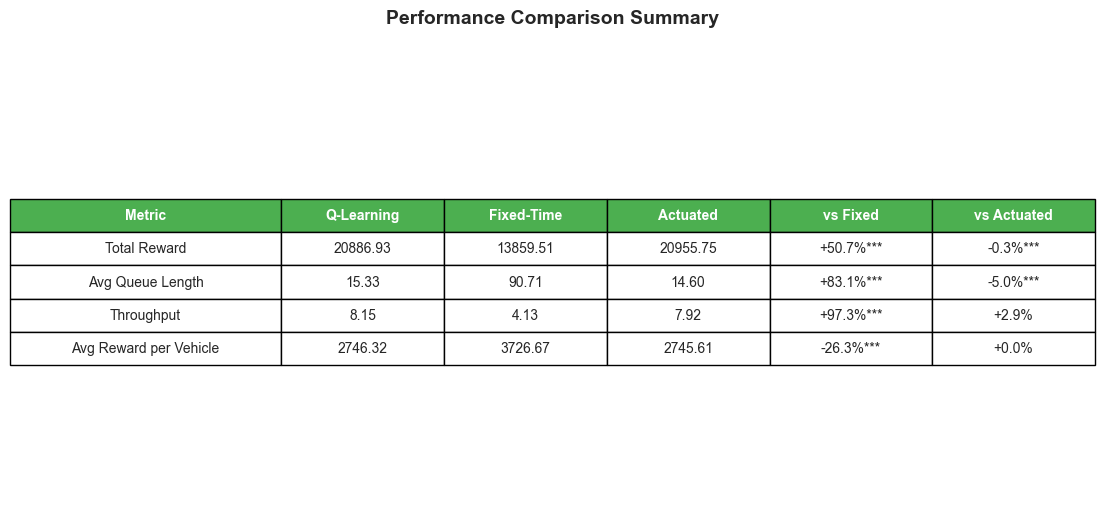

✓ Figure 3 saved: figure_3_comparison_table.png


In [ ]:
# Create comparison table as figure
df_summary = pd.DataFrame(comparison_summary)

fig, ax = plt.subplots(figsize=(14, 6))
ax.axis('tight')
ax.axis('off')

# Format data for table
table_data = []
for _, row in df_summary.iterrows():
    table_data.append([
        row['metric'],
        f"{row['rl_mean']:.2f}",
        f"{row['fixed_mean']:.2f}",
        f"{row['actuated_mean']:.2f}",
        f"{row['imp_vs_fixed']:+.1f}%" + ('***' if row['p_vs_fixed'] < 0.001 else ('**' if row['p_vs_fixed'] < 0.01 else ('*' if row['p_vs_fixed'] < 0.05 else ''))),
        f"{row['imp_vs_actuated']:+.1f}%" + ('***' if row['p_vs_actuated'] < 0.001 else ('**' if row['p_vs_actuated'] < 0.01 else ('*' if row['p_vs_actuated'] < 0.05 else '')))
    ])

table = ax.table(cellText=table_data,
                colLabels=['Metric', 'Q-Learning', 'Fixed-Time', 'Actuated', 'vs Fixed', 'vs Actuated'],
                cellLoc='center',
                loc='center',
                colWidths=[0.25, 0.15, 0.15, 0.15, 0.15, 0.15])

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)

# Style header
for i in range(6):
    table[(0, i)].set_facecolor('#4CAF50')
    table[(0, i)].set_text_props(weight='bold', color='white')

plt.title('Performance Comparison Summary', fontsize=14, fontweight='bold', pad=20)
plt.savefig(f'{RESULTS_OUTPUT_DIR}/figure_3_comparison_table.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Figure 3 saved: figure_3_comparison_table.png")

## 11. Summary Report

In [ ]:
print("\n" + "="*60)
print("FINAL SUMMARY")
print("="*60)

print("\n📊 Generated Figures:")
print("  ✓ Figure 1: Learning Curve")
print("  ✓ Figure 2: Three-Way Performance Comparison")
print("  ✓ Figure 3: Statistical Comparison Table")

print("\n🎯 Key Findings:")
for item in comparison_summary:
    metric = item['metric']
    imp_fixed = item['imp_vs_fixed']
    imp_actuated = item['imp_vs_actuated']
    
    print(f"\n  {metric}:")
    print(f"    vs Fixed-Time: {imp_fixed:+.1f}%")
    print(f"    vs Actuated:   {imp_actuated:+.1f}%")

print("\n" + "="*60)
print("✓ EVALUATION COMPLETE!")
print("="*60)
print("\nAll figures saved in:", RESULTS_OUTPUT_DIR)
print("\nReady for paper submission! 🎉")


FINAL SUMMARY

📊 Generated Figures:
  ✓ Figure 1: Learning Curve
  ✓ Figure 2: Three-Way Performance Comparison
  ✓ Figure 3: Statistical Comparison Table

🎯 Key Findings:

  Total Reward:
    vs Fixed-Time: +50.7%
    vs Actuated:   -0.3%

  Avg Queue Length:
    vs Fixed-Time: +83.1%
    vs Actuated:   -5.0%

  Throughput:
    vs Fixed-Time: +97.3%
    vs Actuated:   +2.9%

  Avg Reward per Vehicle:
    vs Fixed-Time: -26.3%
    vs Actuated:   +0.0%

✓ EVALUATION COMPLETE!

All figures saved in: ../results

Ready for paper submission! 🎉
